In [45]:
#import Libs
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy.stats import spearmanr, pearsonr
import matplotlib.pyplot as plt

In [46]:
#Download dataset
!wget https://opendata.infrabel.be/api/explore/v2.1/catalog/datasets/kilometers-sporen-en-aantal-spoortoestellen-per-gewest/exports/csv?lang=nl&timezone=Europe%2FBerlin&use_labels=true&delimiter=%3B
#Load data
df = pd.read_csv("/content/csv?lang=nl", delimiter=';')

--2024-10-04 18:49:39--  https://opendata.infrabel.be/api/explore/v2.1/catalog/datasets/kilometers-sporen-en-aantal-spoortoestellen-per-gewest/exports/csv?lang=nl
Resolving opendata.infrabel.be (opendata.infrabel.be)... 109.232.232.161, 5.104.97.33
Connecting to opendata.infrabel.be (opendata.infrabel.be)|109.232.232.161|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘csv?lang=nl.4’

csv?lang=nl.4           [ <=>                ]   9.57K  --.-KB/s    in 0s      

2024-10-04 18:49:40 (88.6 MB/s) - ‘csv?lang=nl.4’ saved [9799]



In [47]:
# Affichage des informations du dataset avant le prétraitement
print("=== Informations avant le prétraitement ===")
print(f"Nombre de lignes : {df.shape[0]}")
print(f"Nombre de colonnes : {df.shape[1]}")
print("\nInformations sur les colonnes avant prétraitement :")
df.info()
print("\nAperçu des premières lignes :")
df.head()

=== Informations avant le prétraitement ===
Nombre de lignes : 108
Nombre de colonnes : 9

Informations sur les colonnes avant prétraitement :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   jaar                     108 non-null    int64 
 1   region_gewest            108 non-null    object
 2   gewest                   108 non-null    object
 3   region                   108 non-null    object
 4   type_de_voie_type_spoor  108 non-null    object
 5   type_spoor               108 non-null    object
 6   track_cat                108 non-null    object
 7   kilometer                108 non-null    int64 
 8   aantal_spoortoestellen   108 non-null    int64 
dtypes: int64(3), object(6)
memory usage: 7.7+ KB

Aperçu des premières lignes :


,jaar,region_gewest,gewest,region,type_de_voie_type_spoor,type_spoor,track_cat,kilometer,aantal_spoortoestellen
0,2023,Wallonie,Wallonië,Wallonia,Voie secondaire,Bijspoor,Secondary tracks,583,1337
1,2022,Bruxelles-Capitale,Brussel-Hoofdstad,Brussels,Voie secondaire,Bijspoor,Secondary tracks,114,410
2,2021,Bruxelles-Capitale,Brussel-Hoofdstad,Brussels,Voie secondaire,Bijspoor,Secondary tracks,128,422
3,2021,Flandre,Vlaanderen,Flanders,Voie secondaire,Bijspoor,Secondary tracks,1080,2601
4,2021,Wallonie,Wallonië,Wallonia,Voie principale,Hoofdspoor,Main tracks,2945,1510


In [48]:
#--------------------------------------------------------------------Clean dataset---------------------------------------------------------------------------------------#

# === 1. Suppression des lignes contenant des valeurs NaN dans le dataset ===
df_cleaned = df.dropna()

# === 2. Vérification de la colonne 'Jaar' pour qu'elle contienne uniquement des années entières ===
# Conserver uniquement les lignes où 'Jaar' est un entier
df_cleaned = df_cleaned[df_cleaned['jaar'].apply(lambda x: str(x).isdigit())]
df_cleaned['jaar'] = df_cleaned['jaar'].astype(int)

# === 3. Vérification que les colonnes 'Kilometers sporen' et 'Aantal spoortoestellen' contiennent uniquement des valeurs numériques ===
# Convertir en numérique, et filtrer pour conserver uniquement les valeurs valides
df_cleaned['kilometer'] = pd.to_numeric(df_cleaned['kilometer'], errors='coerce')
df_cleaned['aantal_spoortoestellen'] = pd.to_numeric(df_cleaned['aantal_spoortoestellen'], errors='coerce')

# Supprimer les lignes qui contiennent des valeurs non numériques (NaN) après la conversion
df_cleaned = df_cleaned.dropna(subset=['kilometer', 'aantal_spoortoestellen'])

# === 4. Filtrer la colonne 'Track category' pour ne garder que 'Main tracks' ou 'Secondary tracks' ===
valid_categories = ['Main tracks', 'Secondary tracks']
df_cleaned = df_cleaned[df_cleaned['track_cat'].isin(valid_categories)]

# === 5. Suppression des colonnes en doublon ===
# Supposons que 'Région' est en double avec 'Region' et 'Type de voie' avec 'Type spoor'
duplicate_columns = ['region', 'type_spoor', 'type_de_voie_type_spoor']
df_cleaned = df_cleaned.drop(columns=duplicate_columns)
df = df_cleaned

In [49]:
#encode label
le = LabelEncoder()

# Encodage des colonnes `region_gewest`, `gewest`, et `track_cat`
df['region_gewest'] = le.fit_transform(df['region_gewest'])
df['gewest'] = le.fit_transform(df['gewest'])
df['track_cat'] = le.fit_transform(df['track_cat'])
df

,jaar,region_gewest,gewest,track_cat,kilometer,aantal_spoortoestellen
0,2023,2,2,1,583,1337
1,2022,0,0,1,114,410
2,2021,0,0,1,128,422
3,2021,1,1,1,1080,2601
4,2021,2,2,0,2945,1510
...,...,...,...,...,...,...
103,2007,0,0,0,264,520
104,2007,1,1,0,2987,2084
105,2007,2,2,0,2989,1834
106,2006,0,0,1,237,939


In [50]:
#l'Isolation Forest

# Sélectionner les colonnes numériques pour l'Isolation Forest
numerical_columns = ['jaar', 'region_gewest', 'gewest', 'track_cat', 'kilometer', 'aantal_spoortoestellen']

# Filtrer pour ne garder que les colonnes pertinentes
df_numerical = df[numerical_columns]

# Normaliser les colonnes numériques (important pour l'Isolation Forest)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numerical)

# === 2. Application de l'Isolation Forest ===
# Initialiser le modèle Isolation Forest
model = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)

# Ajuster le modèle sur les données
model.fit(df_scaled)

# Prédire les anomalies (1 = normal, -1 = anomalie)
df['Anomaly'] = model.predict(df_scaled)

# Les anomalies ont une valeur de -1 dans la colonne 'Anomaly'
anomalies = df[df['Anomaly'] == -1]
nn_anomalies = df[df['Anomaly'] == 1]

# === 4. Affichage des résultats ===
print("Nombre total de lignes dans le dataset : ", len(df))
print("Nombre d'anomalies détectées : ", len(anomalies))
print("\nAperçu des anomalies détectées :")
anomalies
#nn_anomalies



Nombre total de lignes dans le dataset :  108
Nombre d'anomalies détectées :  2

Aperçu des anomalies détectées :


,jaar,region_gewest,gewest,track_cat,kilometer,aantal_spoortoestellen,Anomaly
85,2006,2,2,1,989,3057,-1
107,2006,1,1,1,1560,4382,-1


=== Corrélation de Pearson ===

=== Corrélation de Spearman ===


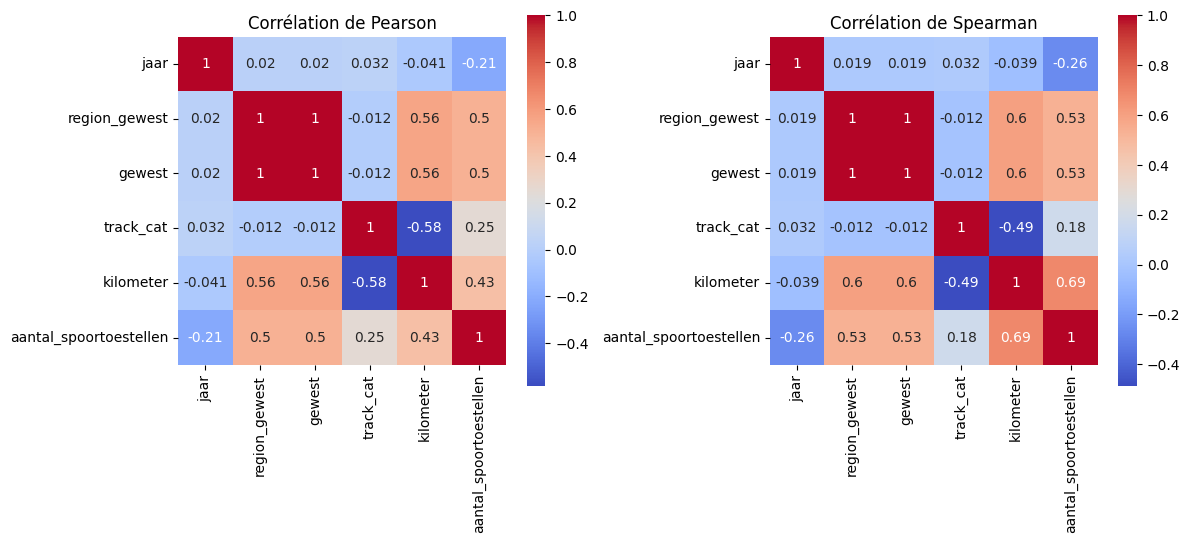

In [51]:
df = nn_anomalies

# Sélectionner les colonnes numériques pour calculer les corrélations
numerical_columns = ['jaar', 'region_gewest', 'gewest', 'track_cat', 'kilometer', 'aantal_spoortoestellen']


# === 1. Calcul de la corrélation de Pearson ===
pearson_corr = df[numerical_columns].corr(method='pearson')
print("=== Corrélation de Pearson ===")
#print(pearson_corr)

# === 2. Calcul de la corrélation de Spearman ===
spearman_corr = df[numerical_columns].corr(method='spearman')
print("\n=== Corrélation de Spearman ===")
#print(spearman_corr)

# === 3. Visualisation des corrélations avec une heatmap ===
plt.figure(figsize=(12, 6))

# Heatmap pour la corrélation de Pearson
plt.subplot(1, 2, 1)
sns.heatmap(pearson_corr, annot=True, cmap='coolwarm', square=True, cbar_kws={'shrink': .8})
plt.title('Corrélation de Pearson')

# Heatmap pour la corrélation de Spearman
plt.subplot(1, 2, 2)
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', square=True, cbar_kws={'shrink': .8})
plt.title('Corrélation de Spearman')

plt.tight_layout()
plt.show()


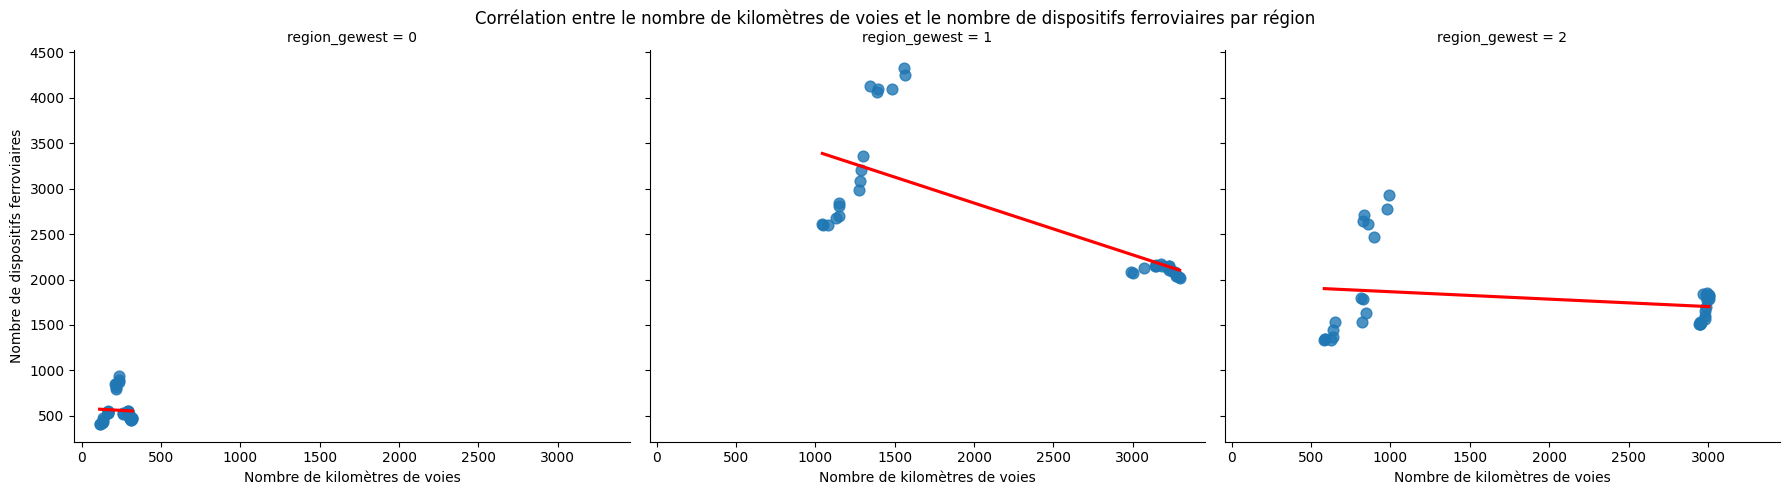

In [52]:
# Définir la taille de la figure avec Seaborn's FacetGrid
g = sns.FacetGrid(df, col="region_gewest", col_wrap=3, height=5, aspect=1.2, sharex=True, sharey=True)

# Appliquer la carte de dispersion et la ligne de régression pour chaque région
g = g.map(sns.regplot, "kilometer", "aantal_spoortoestellen", scatter_kws={'s': 60, 'color': '#1f77b4'}, line_kws={'color': 'red'}, ci=None)

# Ajouter les labels aux axes
g.set_axis_labels("Nombre de kilomètres de voies", "Nombre de dispositifs ferroviaires")

# Ajouter un titre global
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Corrélation entre le nombre de kilomètres de voies et le nombre de dispositifs ferroviaires par région")

# Afficher le graphique
plt.show()


<ipython-input-53-72cb84d513d2>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='region_gewest', y='kilometer', data=kilometers_per_region, palette='coolwarm')
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarnin

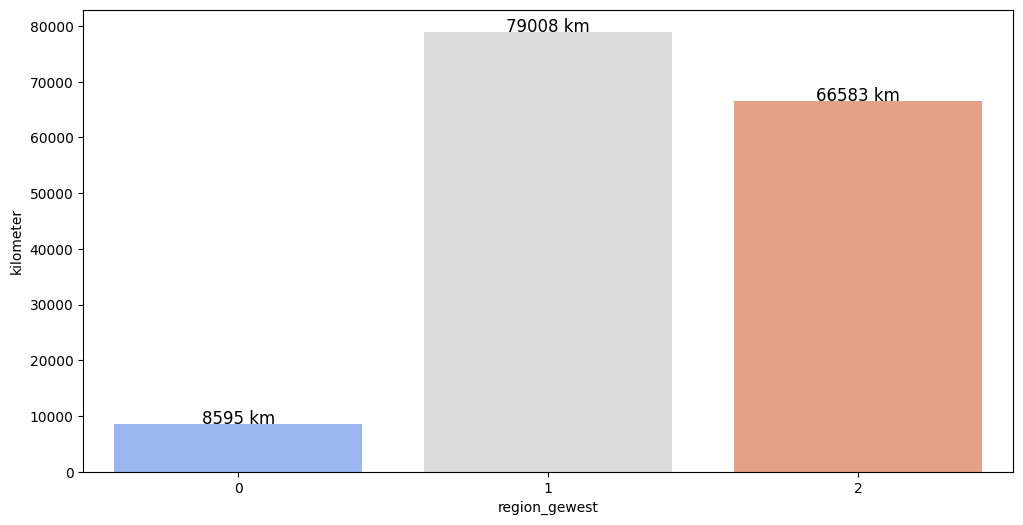

In [53]:
# Agréger le nombre total de kilomètres par région
kilometers_per_region = df.groupby('region_gewest')['kilometer'].sum().reset_index()
# Définir la taille de la figure
plt.figure(figsize=(12, 6))

# Créer un barplot pour illustrer le nombre total de kilomètres par région
sns.barplot(x='region_gewest', y='kilometer', data=kilometers_per_region, palette='coolwarm')

# Ajouter des valeurs au-dessus de chaque barre pour la lisibilité
for index, value in enumerate(kilometers_per_region['kilometer']):
    plt.text(index, value + 50, f"{int(value)} km", ha='center', fontsize=12, color='black')

# Ajouter le titre


<ipython-input-54-0aba5eb143c8>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='region_gewest', y='aantal_spoortoestellen', data=devices_per_region, palette='viridis')
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: Fut

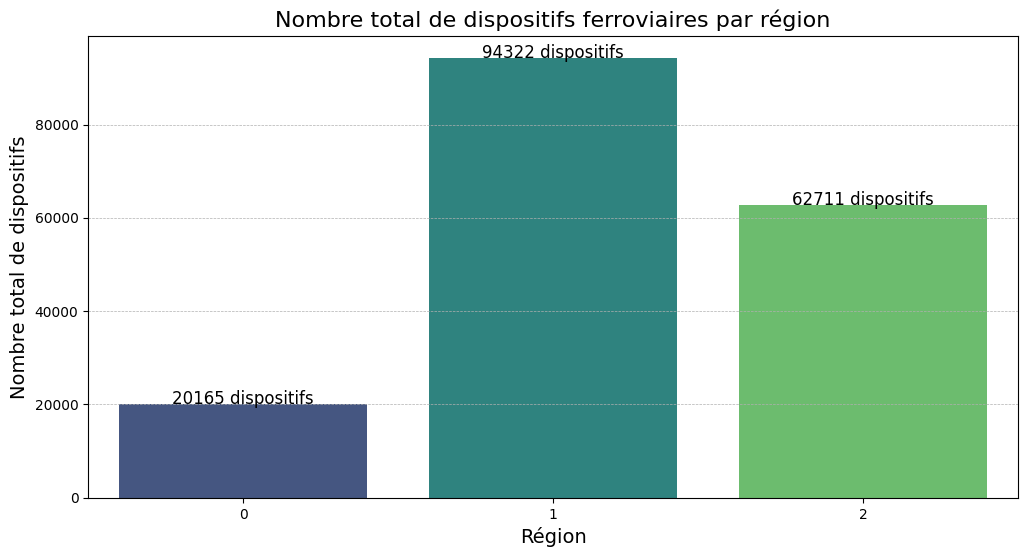

In [54]:
# Agréger le nombre total de dispositifs ferroviaires par région
devices_per_region = df.groupby('region_gewest')['aantal_spoortoestellen'].sum().reset_index()

# Définir la taille de la figure
plt.figure(figsize=(12, 6))

# Créer un barplot pour illustrer le nombre total de dispositifs par région
sns.barplot(x='region_gewest', y='aantal_spoortoestellen', data=devices_per_region, palette='viridis')

# Ajouter des valeurs au-dessus de chaque barre
for index, value in enumerate(devices_per_region['aantal_spoortoestellen']):
    plt.text(index, value + 50, f"{int(value)} dispositifs", ha='center', fontsize=12, color='black')

# Ajouter le titre et les labels
plt.title("Nombre total de dispositifs ferroviaires par région", fontsize=16)
plt.xlabel("Région", fontsize=14)
plt.ylabel("Nombre total de dispositifs", fontsize=14)

# Afficher la grille
plt.grid(visible=True, linestyle='--', linewidth=0.5, axis='y')

# Afficher le graphique
plt.show()


<ipython-input-55-5cd9fa2cf225>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='track_cat', y='kilometer', data=km_per_track, palette='magma')
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


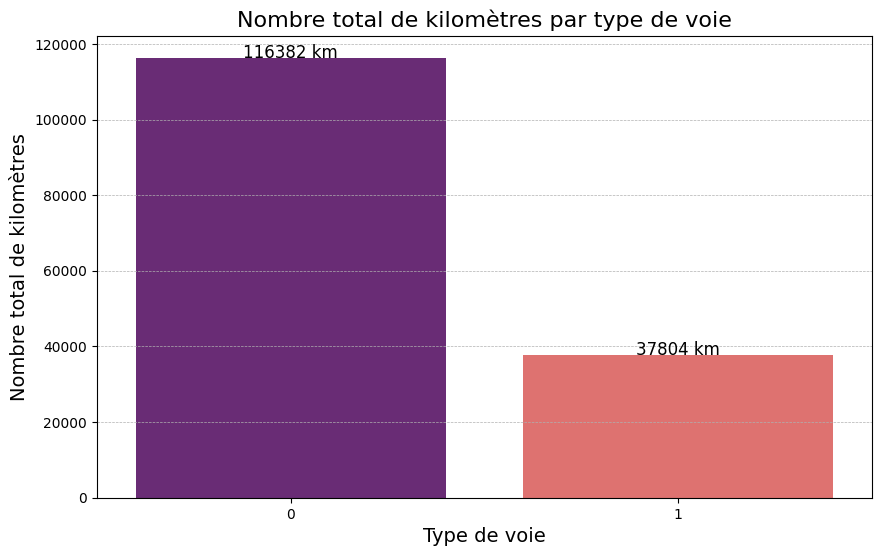

In [55]:
# Calculer le total des kilomètres pour chaque catégorie de voie
km_per_track = df.groupby('track_cat')['kilometer'].sum().reset_index()

# Définir la taille de la figure
plt.figure(figsize=(10, 6))

# Créer un barplot pour illustrer le total des kilomètres par type de voie
sns.barplot(x='track_cat', y='kilometer', data=km_per_track, palette='magma')

# Ajouter le titre et les labels
plt.title("Nombre total de kilomètres par type de voie", fontsize=16)
plt.xlabel("Type de voie", fontsize=14)
plt.ylabel("Nombre total de kilomètres", fontsize=14)

# Afficher les valeurs au-dessus de chaque barre
for index, value in enumerate(km_per_track['kilometer']):
    plt.text(index, value + 50, f"{int(value)} km", ha='center', fontsize=12, color='black')

# Afficher la grille pour faciliter la lecture
plt.grid(visible=True, linestyle='--', linewidth=0.5, axis='y')

# Afficher le graphique
plt.show()


<ipython-input-56-7e385af20e0e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['jaar'] = data['jaar'].astype(int)


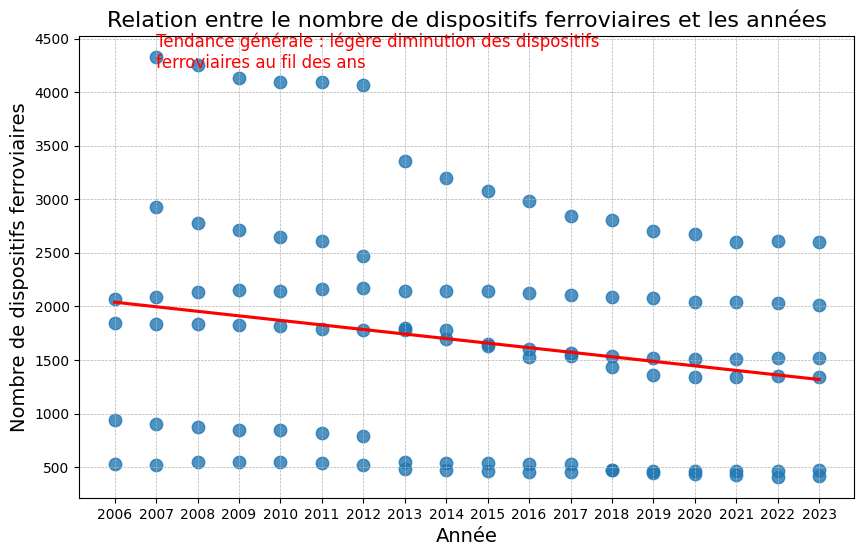

In [56]:
data = df
# S'assurer que 'jaar' est de type entier
data['jaar'] = data['jaar'].astype(int)

# Définir la taille de la figure
plt.figure(figsize=(10, 6))

# Créer le scatter plot avec une droite de régression
sns.regplot(x='jaar', y='aantal_spoortoestellen', data=data,
            scatter_kws={'s': 80, 'color': '#1f77b4'}, line_kws={'color': 'red'}, ci=None)

# Personnalisation des axes et du titre
plt.title("Relation entre le nombre de dispositifs ferroviaires et les années", fontsize=16)
plt.xlabel("Année", fontsize=14)
plt.ylabel("Nombre de dispositifs ferroviaires", fontsize=14)

# Ajouter des graduations spécifiques aux années entières
plt.xticks(ticks=data['jaar'].unique(), labels=[str(year) for year in data['jaar'].unique()])

# Annotation pour montrer la tendance de la corrélation négative
plt.text(data['jaar'].min() + 1, data['aantal_spoortoestellen'].max() - 100,
         "Tendance générale : légère diminution des dispositifs\nferroviaires au fil des ans", fontsize=12, color='red')

# Affichage de la grille pour faciliter la lecture
plt.grid(visible=True, linestyle='--', linewidth=0.5)

# Afficher le graphique
plt.show()
